In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
import pandas as pd
matplotlib.use('Agg')
import pandas as pd
import seaborn as sns
class ip:
    #Ip for 'inverse problem'
    # Initialize prior chain starting point,
    # chain burn-in length and total length, and 
    # Q (for proposal samples).  
    # Initialize experimental data.
    # theta = np.array([0.15,5.])
    # theta is initialized as the starting point
    # of the chain.  It is placed at the prior
    # mean.
    kB = 8.61733035E-5 #eV/K
    T = 298.15 #K
    mcmc_length = 100000
    mcmc_burn_in = 20000
    # trimmed off the beginning of the Markov
    # chain
    mu_prior = np.array([-0.15]) # (eV)
    cov_prior = np.array([[0.1**2]])
    experiment = -3.912
    Q_mu = np.array([0]) # Q samples the next step at any point
    # in the chain.  The next step may be accepted or rejected.  Q_mu
    # is centered (0) around the current theta.
    Q_cov = cov_prior/20 # Take small steps.
    
    #main function to get samples
    def MetropolisHastings(self):
        samples = np.zeros((self.mcmc_length,1))
        samples[0,:] = self.mu_prior #initialize the chain
        likelihoods_vec = np.zeros((self.mcmc_length,1))
        posteriors_un_normed_vec = np.zeros((self.mcmc_length,1))
        priors_vec = np.zeros((self.mcmc_length,1))
        for i in range(1,self.mcmc_length):
            proposal_sample = samples[i-1,:] + \
                np.random.multivariate_normal( \
                self.Q_mu,self.Q_cov)
            prior_proposal = self.prior(proposal_sample)
            likelihood_proposal = self.likelihood(proposal_sample)
            prior_current_location = self.prior(samples[i-1,:])
            likelihood_current_location = self.likelihood(samples[i-1,:])
            accept_pro = (likelihood_proposal*prior_proposal)/ \
                (likelihood_current_location*prior_current_location)
            uni_rand = np.random.uniform()
            if uni_rand<accept_pro:
                samples[i,:] = proposal_sample
                posteriors_un_normed_vec[i] = \
                         likelihood_proposal*prior_proposal
                likelihoods_vec[i] = likelihood_proposal
                priors_vec[i] = prior_proposal
            else:
                samples[i,:] = samples[i-1,:]
                posteriors_un_normed_vec[i] = likelihood_current_location* \
                         prior_current_location
                likelihoods_vec[i] = likelihood_current_location
                priors_vec[i] = prior_current_location
            ########################################
        samples = samples[self.mcmc_burn_in:]
        posteriors_un_normed_vec = posteriors_un_normed_vec[self.mcmc_burn_in:]
        likelihoods_vec = likelihoods_vec[self.mcmc_burn_in:]
        priors_vec = priors_vec[self.mcmc_burn_in:]
        evidence = np.mean(posteriors_un_normed_vec)*np.sqrt(2*np.pi*np.std(samples)**2)
        posteriors_vec = posteriors_un_normed_vec/evidence
        log_ratios = np.log(posteriors_vec/priors_vec)
        log_ratios[np.isinf(log_ratios)] = 0
        print('Posteriors and Priors:\n',np.column_stack((posteriors_vec,priors_vec)))
        log_ratios = np.nan_to_num(log_ratios)
        info_gain = np.mean(log_ratios)
        return [evidence, info_gain, samples]
    
    def prior(self,sample):
    
        probability = multivariate_normal.pdf(x=sample,
                         mean=self.mu_prior, 
                         cov=self.cov_prior)
        #print('prior: ' + str(probability))
        return probability
        
    def likelihood(self,sample):
        K_eq = np.exp(-sample/(self.kB*self.T))
        ln_CA = np.log(1/(1+K_eq))
        probability = multivariate_normal.pdf(x=ln_CA, \
               mean=self.experiment, cov=1) # Here we are putting
        #in the model and experiment
        #print('sample goose 0: ' + str(sample[0]))
        #print('experiment: ' + str(self.experiment))
        #print('likelihood: ' + str(probability))
        
        return probability



Temperature:298.15 K
Posteriors and Priors:
 [[21.10450235  3.45876882]
 [21.10450235  3.45876882]
 [16.36947727  3.20565236]
 ...
 [ 5.69954497  3.98297049]
 [ 7.79925316  3.96629093]
 [ 9.91199266  3.94339696]]
evidence 0.06482636385636092 info_gain 1.3326319587499404
Temperature:398.15 K
Posteriors and Priors:
 [[ 9.19715789  3.96979384]
 [14.4874452   3.80381551]
 [10.33352239  3.95124691]
 ...
 [15.12254984  3.75098214]
 [11.74670164  3.91871632]
 [13.70810721  3.84785314]]
evidence 0.09075989727555414 info_gain 1.0094735258675822
Temperature:498.15 K
Posteriors and Priors:
 [[11.50382552  3.87447507]
 [12.21029069  3.79050254]
 [ 4.77987148  2.35184089]
 ...
 [ 6.30038628  2.60168138]
 [12.43626869  3.73057766]
 [ 7.97315446  3.98842926]]
evidence 0.11482933255750286 info_gain 0.8140504637607618
Temperature:598.15 K
Posteriors and Priors:
 [[10.48614067  3.66228992]
 [10.48614067  3.66228992]
 [10.45996749  3.78641303]
 ...
 [ 9.49248633  3.94203832]
 [ 9.49248633  3.94203832]
 [

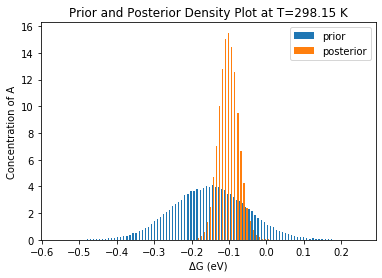

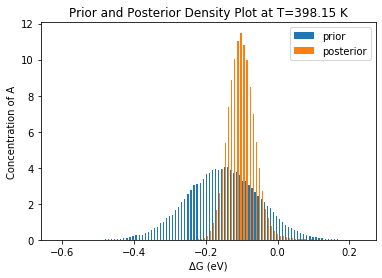

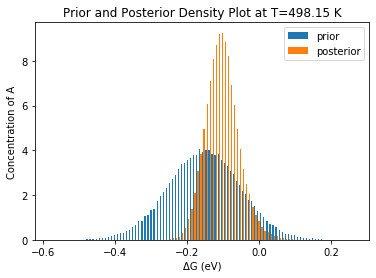

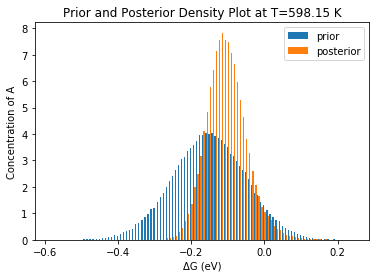

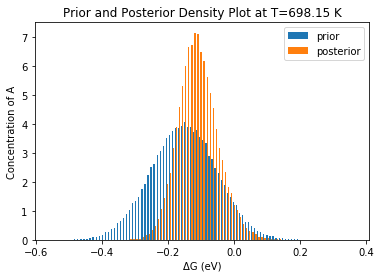

In [2]:
ip_object = ip()
rxn_exp=-0.1 #eV
kB = 8.61733035E-5 #eV/K
T_space = np.array([298.15,398.15,498.15,598.15,698.15])
experiments = np.log(1/(1+(np.exp(-rxn_exp \
                                  /(kB*np.linspace(298.15,698.15,5))))))
evidences=[]
info_gains=[]
all_samples=[]
for i in range(len(T_space)):
    ip_object.experiment = experiments[i]
    ip_object.T=T_space[i] #K
    print('Temperature:'+str(T_space[i])+' K')
    [evidence, info_gain, samples] = ip_object.MetropolisHastings()
    print('evidence',evidence,'info_gain',info_gain)
    evidences.append(evidence)
    info_gains.append(info_gain)
    fig, ax = plt.subplots()
    prior = np.random.normal(-0.15,0.1,80000)
    (density0,bins0,pathces0)=ax.hist([prior,samples.ravel()],bins=100,label=['prior','posterior'],density=True)
    all_samples.append(samples)
    ax.legend()
    ax.set_xlabel(u'ΔG (eV)')
    ax.set_ylabel('Concentration of A')
    ax.set_title('Prior and Posterior Density Plot at T='+str(T_space[i])+' K')
    fig.savefig('posterior_G_'+str(i)+'.png', dpi=300)

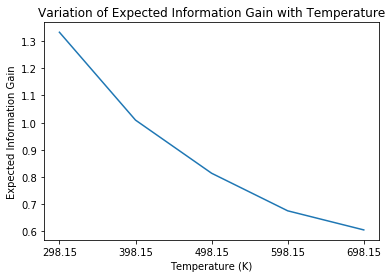

In [3]:
fig,ax = plt.subplots()
ax.plot(T_space,info_gains)
ax.set_xlabel('Temperature (K)')
ax.set_xticks(T_space)
ax.set_xticklabels(T_space)
ax.set_ylabel('Expected Information Gain')
ax.set_title('Variation of Expected Information Gain with Temperature')
fig.savefig('info_gain_vs_T.png', dpi=300)

info_gain: 0.6055727517268709


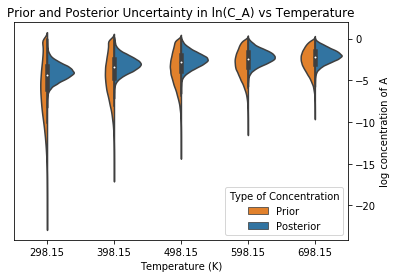

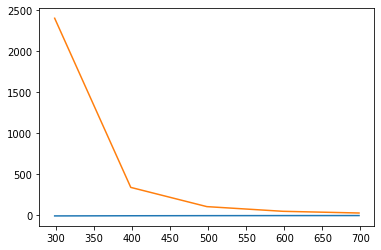

In [6]:
# Empty dataframe
df_consolidated = pd.DataFrame()

# Calculating prior concentrations
for i in range(len(T_space)):
    k=np.exp(-(np.random.normal(-0.15,0.1,80000))/(kB*T_space[i]))
    C_A=np.log(1/(1+k))
    df_prior=pd.DataFrame({'Temperature':T_space[i],'Concentration':C_A.flatten(),'C_type':'Prior'})
    df_consolidated=df_consolidated.append(df_prior,ignore_index=True)
    
# Calculating posterior concentrations
for i in range(len(T_space)):
    k=np.exp(-(all_samples[i])/(kB*T_space[i]))
    C_A=np.log(1/(1+k))
    df_post=pd.DataFrame({'Temperature':T_space[i],'Concentration':C_A.flatten(),'C_type':'Posterior'})
    df_consolidated=df_consolidated.append(df_post,ignore_index=True)
       

# fig,ax = plt.subplots()
plt.figure()
ax= sns.violinplot(x='Temperature',y='Concentration',hue='C_type',data=df_consolidated,split=True,palette={"Prior":"C1","Posterior":"C0"})
ax.legend(loc='lower right',title='Type of Concentration')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylabel(r'log concentration of A')
ax.set_xlabel(r'Temperature (K)')
ax.set_title('Prior and Posterior Uncertainty in ln(C_A) vs Temperature')
plt.savefig('C_A_violin.png', dpi=300)

print('info_gain: ' + str(info_gain))
fig,ax = plt.subplots()
ax.plot(T_space,np.log(1/(1+np.exp(-(-0.2)/(T_space*kB)))))
ax.plot(T_space,np.exp(-(-0.2)/(T_space*kB)))
fig.savefig('CavsT.png', dpi=300)